<a href="https://colab.research.google.com/github/DarkSchneider/Exercises/blob/main/Traccia_progettoF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Informazioni consegna
* Aggiungere i componenti del proprio gruppo in questo [form](https://forms.office.com/r/1WKBx4YgSH). 
* **I gruppi possono essere composti da massimo 3 persone. Nel caso si intenda fare il progetto da soli bisogna comunque aggiungere il proprio nome nel form.**
* Per la consegna è necessario caricare su Virtuale la relazione, il notebook Colab e le immagini generate.
* La consegna deve essere effettuata da un qualsiasi membro del gruppo e verrà automaticamente attribuita ai restanti componenti.
* Per i dettagli sulle tempistiche e le scadenze si faccia riferimento a Virtuale.

# Deblur Immagini
Il problema di deblur consiste nella ricostruzione di un immagine a partire da un dato acquisito mediante il seguente modello:

\begin{align*}
    b = A x + \eta
\end{align*}

dove $b$ rappresenta l'immagine corrotta, $x$ l'immagine originale che vogliamo ricostruire, $A$ l'operatore che applica il blur Gaussiano ed $\eta$ il rumore additivo con distribuzione Gaussiana di  media $\mathbb{0}$ e deviazione standard $\sigma$.

## Funzioni di blur
Le seguenti funzioni servono per applicare il blur di tipo gaussiano ad un'immagine.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, metrics
from scipy import signal
from numpy import fft

# Create a Gaussian kernel of size kernlen and standard deviation sigma
def gaussian_kernel(kernlen, sigma):
    x = np.linspace(- (kernlen // 2), kernlen // 2, kernlen)    
    # Unidimensional Gaussian kernel
    kern1d = np.exp(- 0.5 * (x**2 / sigma))
    # Bidimensional Gaussian kernel
    kern2d = np.outer(kern1d, kern1d)
    # Normalization
    return kern2d / kern2d.sum()

# Compute the FFT of the kernel 'K' of size 'd' padding with the zeros necessary
# to match the size of 'shape'
def psf_fft(K, d, shape):
    # Zero padding
    K_p = np.zeros(shape)
    K_p[:d, :d] = K

    # Shift
    p = d // 2
    K_pr = np.roll(np.roll(K_p, -p, 0), -p, 1)

    # Compute FFT
    K_otf = fft.fft2(K_pr)
    return K_otf

# Multiplication by A
def A(x, K):
  x = fft.fft2(x)
  return np.real(fft.ifft2(K * x))

# Multiplication by A transpose
def AT(x, K):
  x = fft.fft2(x)
  return np.real(fft.ifft2(np.conj(K) * x))

## Generazione dataset
Generare un set di 8 immagini 512$\times$512 in formato ${\tt png}$ in scala dei grigi che contengano tra i 2 ed i 6 oggetti geometrici, di colore uniforme, su sfondo nero. 


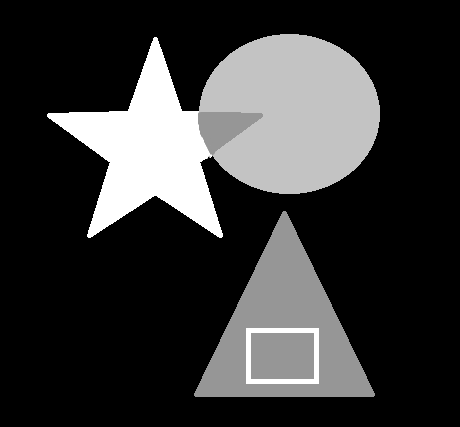


## 1) Generazione immagini corrotte
Degradare le immagini applicando, mediante le funzioni riportate nella cella precedente,  l'operatore di blur con parametri

+ $\sigma=0.5$ dimensione $5\times 5$
+ $\sigma=1$ dimensione $7\times 7$
+ $\sigma=1.3$ dimensione $9\times 9$

ed aggiungendo rumore gaussiano con deviazione standard $(0,0.05]$

In [2]:
import matplotlib.pyplot as plt
from skimage import color, io, metrics
import sys
from google.colab import files


#lettura delle immagini e renderle in colormap bianco e nero
immagini=[]
for i in range(8):
  immagini.append(np.array(color.rgb2gray(plt.imread('{}.png'.format(i+1)))))

#aggiungere il blur
k1 = gaussian_kernel(5,0.5)
k2 = gaussian_kernel(7,1)
k3 = gaussian_kernel(9,1.3)

dim = immagini[i].shape

#filtro di blur
f1 = psf_fft(k1, 5, dim)
f2 = psf_fft(k2, 7, dim)
f3 = psf_fft(k3, 9, dim)


#rumore
sigma = 0.04

#moltiplicare tutto
imblur1 = []
imblur2 = []
imblur3 = []

for i in range(8):
    noise = np.random.normal(size=dim) * sigma
    imblur1.append(np.array(A(immagini[i], f1) + noise))
    imblur2.append(np.array(A(immagini[i], f2) + noise))
    imblur3.append(np.array(A(immagini[i], f3) + noise))

    #calcolare psnr e mse tra (immagini, imblur)
    PSNR = metrics.peak_signal_noise_ratio(immagini[i], imblur1[i])
    MSE = metrics.mean_squared_error(immagini[i], imblur1[i])
    print('PSNR immagine-{}: {}'.format(i,PSNR))
    print('MSE immagine-{}: {}'.format(i,MSE))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.


PSNR immagine-0: 27.11622036113294
MSE immagine-0: 0.0019425757541865853
PSNR immagine-1: 27.433781010137693
MSE immagine-1: 0.001805601467267864
PSNR immagine-2: 27.661986393284202
MSE immagine-2: 0.0017131735501865165
PSNR immagine-3: 27.749142246257733
MSE immagine-3: 0.00167913562322052
PSNR immagine-4: 27.864332868622498
MSE immagine-4: 0.0016351843168776843
PSNR immagine-5: 27.40160641040436
MSE immagine-5: 0.0018190278945378374
PSNR immagine-6: 27.516975667623896
MSE immagine-6: 0.0017713420530222183
PSNR immagine-7: 27.558953842442875
MSE immagine-7: 0.0017543030391820214


## 2) Soluzione naive

Una possibile ricostruzione dell'immagine originale $x$ partendo dall'immagine corrotta $b$ è la soluzione naive data dal minimo del seguente problema di ottimizzazione:
\begin{align}
  x^* = \arg\min_x \frac{1}{2} ||Ax - b||_2^2
\end{align}

La funzione $f$ da minimizzare è data dalla formula
  $f(x) = \frac{1}{2} ||Ax - b||_2^2 $, il cui gradiente $\nabla f$ è dato da
$\nabla f(x) = A^TAx - A^Tb  $.

Utilizzando il metodo del gradiente coniugato implementato dalla funzione `minimize` calcolare la soluzione naive. 

         Current function value: 108.434997
         Iterations: 30
         Function evaluations: 64
         Gradient evaluations: 64
     fun: 108.43499746540878
     jac: array([-0.0008219 , -0.00070023, -0.00128705, ..., -0.00076375,
       -0.00044253, -0.00027958])
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 64
     nit: 30
    njev: 64
  status: 1
 success: False
       x: array([ 0.31847856, -0.11542432, -0.32410444, ..., -0.55975399,
       -0.23917849,  0.04597462])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

         Current function value: 107.502287
         Iterations: 30
         Function evaluations: 64
         Gradient evaluations: 64
     fun: 107.5022865966835
     jac: array([ 1.81548699e-04,  5.60192515e-05, -5.28561040e-04, ...,
        2.62376579e-05,  1.62468285e-04,  1.77415490e-04])
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 64
     nit: 30
    njev: 64
  status: 1
 success: False
       x: array([-0.13534533,  0.19940582,  0.60479493, ...,  0.11914102,
       -0.24181406, -0.48712417])


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

         Current function value: 107.523606
         Iterations: 30
         Function evaluations: 64
         Gradient evaluations: 64
     fun: 107.52360566447965
     jac: array([-1.22694604e-03,  9.20407262e-04, -2.56558750e-05, ...,
        7.23808809e-04,  2.30971753e-04, -1.67383776e-03])
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 64
     nit: 30
    njev: 64
  status: 1
 success: False
       x: array([0.00663139, 0.42631609, 0.21032388, ..., 0.91613942, 0.98301643,
       0.39344145])


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

         Current function value: 108.152042
         Iterations: 30
         Function evaluations: 62
         Gradient evaluations: 62
     fun: 108.15204155884297
     jac: array([-2.63920338e-05,  2.88040733e-04,  6.89981744e-04, ...,
       -6.02683471e-04, -6.19543606e-05, -2.66563358e-04])
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 62
     nit: 30
    njev: 62
  status: 1
 success: False
       x: array([ 0.11537575, -0.4809095 , -0.37060423, ...,  0.15063044,
        0.01633909, -0.42589398])


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

         Current function value: 106.904712
         Iterations: 30
         Function evaluations: 63
         Gradient evaluations: 63
     fun: 106.90471227074826
     jac: array([-0.00020716, -0.00054239, -0.0013598 , ...,  0.00061584,
        0.00045296, -0.00024395])
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 63
     nit: 30
    njev: 63
  status: 1
 success: False
       x: array([ 7.53598160e-02, -5.13852634e-04, -3.09423010e-01, ...,
        9.39318724e-02, -7.64015815e-02, -5.20270044e-01])


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

         Current function value: 110.136229
         Iterations: 30
         Function evaluations: 64
         Gradient evaluations: 64
     fun: 110.13622914294696
     jac: array([ 0.00017542, -0.00016274, -0.00114977, ..., -0.00144463,
       -0.0018854 , -0.00140948])
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 64
     nit: 30
    njev: 64
  status: 1
 success: False
       x: array([ 0.282198  ,  0.70270258,  0.38146445, ...,  0.31076586,
        0.12641141, -1.11361418])


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

         Current function value: 108.351206
         Iterations: 30
         Function evaluations: 62
         Gradient evaluations: 62
     fun: 108.35120642233838
     jac: array([-0.00071116, -0.00044178, -0.00044208, ..., -0.00052324,
       -0.00037327, -0.00059806])
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 62
     nit: 30
    njev: 62
  status: 1
 success: False
       x: array([-0.03589175, -0.05722784, -0.63531846, ..., -0.07735897,
        0.54675481, -0.02900035])


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

         Current function value: 108.510847
         Iterations: 30
         Function evaluations: 62
         Gradient evaluations: 62
     fun: 108.51084672215752
     jac: array([ 0.00013028, -0.00057861,  0.0003076 , ...,  0.00252825,
        0.00074771, -0.00063043])
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 62
     nit: 30
    njev: 62
  status: 1
 success: False
       x: array([ 0.01072589,  0.03172296, -0.31952489, ..., -0.11096219,
        0.05262688,  0.40004434])


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

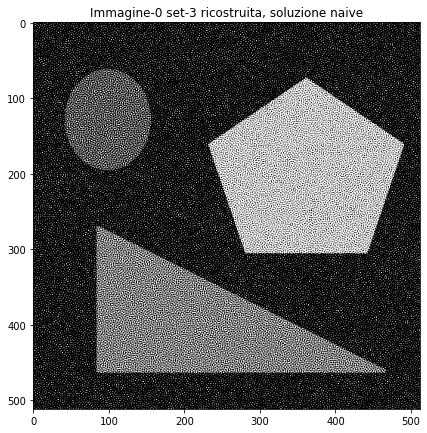

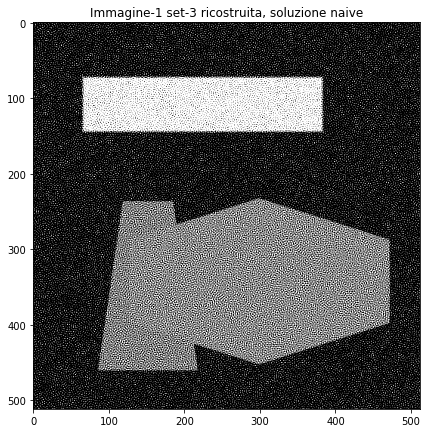

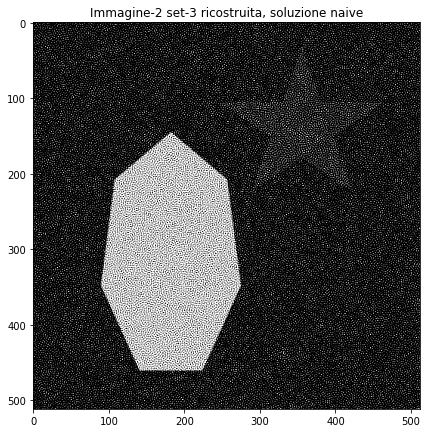

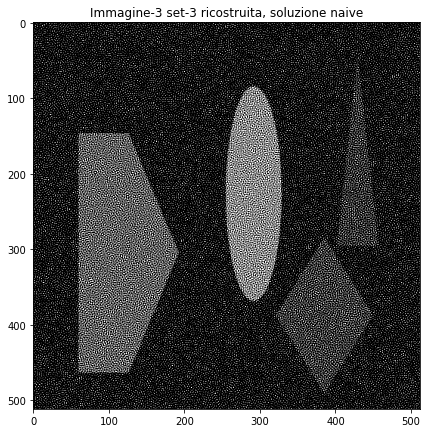

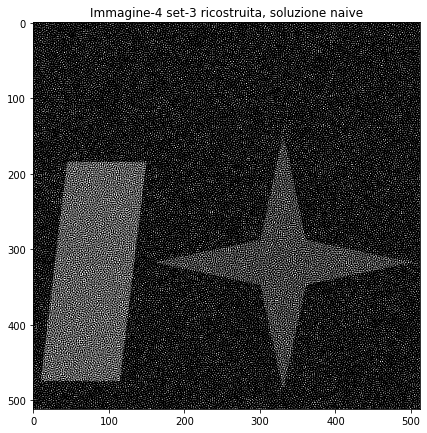

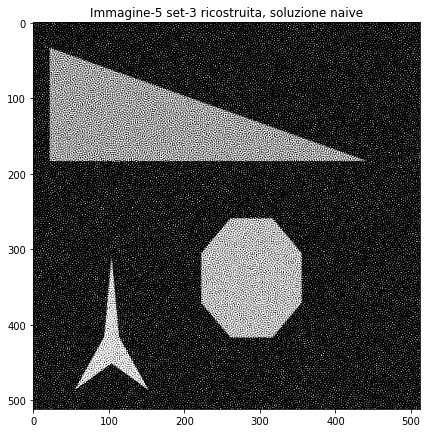

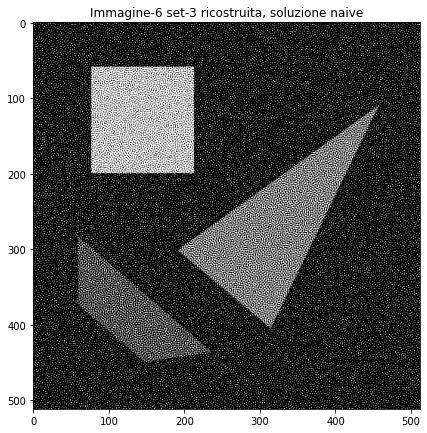

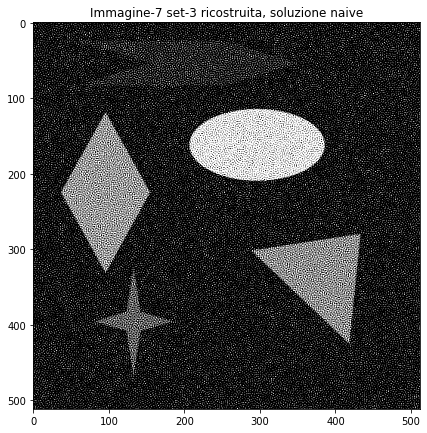

In [3]:
from scipy.optimize import minimize
#filtro di blur attualmente utilizzato, cambiare questo per cambiare la A a seconda del blur che si vuole usare
blur = f3

if blur.all() == f3.all():
  set_number = 3
elif blur.all() == f2.all():
  set_number = 2
elif blur.all() == f1.all():
  set_number = 1
else:
  set_number = 99

#funzione per trovare i pollici partendo da pixel
def pixel2inch(num,dpi):
  return num/dpi

#ignoro il rumore

def f(x):
  x_matrix = x.reshape((immagini[0].shape[0], immagini[0].shape[1]))
  #print(0.5*np.linalg.norm(A(x_matrix,blur) - b))
  r = 0.5*(np.linalg.norm(A(x_matrix, blur) - b)**2)
  return np.sum(r)

def grad_f(x):
  x_matrix = x.reshape(immagini[0].shape[0], immagini[0].shape[0])  #formo la matrice
  r = AT(A(x_matrix,blur) - b, blur)
  r = r.reshape(r.shape[0]**2)
  return r

for i in range(8):
  b=imblur3[i]
  x0 = np.zeros(immagini[0].shape[0]**2)

  res = minimize(f, x0, method='CG', jac=grad_f, options={'disp':True, 'maxiter':30})

  print(res)

  x = res.x.reshape((512,512))
  
  psnr = metrics.peak_signal_noise_ratio(immagini[i], x)

  plt.figure(figsize=(pixel2inch(512,72),pixel2inch(512,72))) #72dpi
  ax = plt.subplot()
  ax.imshow(x, cmap='gray', vmin=0, vmax=1)
  plt.title('Immagine-' + str(i) + ' set-{} ricostruita, soluzione naive'.format(set_number))
  plt.imsave('Immagine-' + str(i) + ' set-{} ricostruita, soluzione naive.png'.format(set_number),x, cmap=plt.cm.gray, vmin=0, vmax=1)
  files.download('Immagine-' + str(i) + ' set-{} ricostruita, soluzione naive.png'.format(set_number))


## 3) Regolarizzazione
Per ridurre gli effetti del rumore nella ricostruzione è necessario introdurre un termine di regolarizzazione di Tikhonov. Si considera quindi il seguente problema di ottimizzazione.
\begin{align*}
  x^* = \arg\min_x \frac{1}{2} ||Ax - b||_2^2 + \frac{\lambda}{2} ||x||_2^2
\end{align*}

La funzione $f$ da minimizzare diventa
$f(x) = \frac{1}{2} ||Ax - b||_2^2 + \frac{\lambda}{2} ||x||_2^2$
il cui gradiente $\nabla f$ è dato da
$\nabla f(x) = A^TAx - A^Tb + λx$.

Utilizzando il metodo del gradiente coniugato implementato dalla funzione `minimize` ed il metodo del gradiente implementato a lezione, calcolare la soluzione del precendente problema di minimo regolarizzato per differenti valori di $\lambda$. 

In [4]:
#implementazione metodo del gradiente
#backtrackng
def next_step(x,grad): # backtracking procedure for the choice of the steplength
    alpha=1.1 
    rho = 0.5 #parametro con cui divido alpha dopo ogni iterazione
    c1 = 0.25 #parametro fisso
    p=-grad
    j=0
    jmax=10
    while ((f(x[0]+alpha*p[0],x[1]+alpha*p[1]) > f(x[0],x[1])+c1*alpha*grad.T@p) and j<jmax ): #condizioni di wolfe per la ricerca in linea inesatta
      alpha= rho*alpha
      j+=1
    if (j>jmax):
      return -1
    else:
      #print('alpha=',alpha)
      return alpha

#metodo del gradiente
def grad_minimize(x0,b,mode,step,MAXITERATION,ABSOLUTE_STOP):
  #declare x_k and gradient_k vectors
  if mode=='plot_history':
    x=np.zeros((2,MAXITERATION))

  norm_grad_list=np.zeros((1,MAXITERATION))
  function_eval_list=np.zeros((1,MAXITERATION))
  error_list=np.zeros((1,MAXITERATION))
  
  #initialize first values
  x_last = np.array([x0[0],x0[1]])

  if mode=='plot_history':
    x[:,0] = x_last
  
  k=0

  function_eval_list[:,k]=f(x_last[0], x_last[1])
  error_list[:,k]=np.linalg.norm(x_last-b)
  norm_grad_list[:,k]=np.linalg.norm(grad_f(x_last))

  while (np.linalg.norm(grad_f(x_last))>ABSOLUTE_STOP and k < MAXITERATION ):
    k=k+1
    grad = grad_f(x_last) #direction is given by gradient of the last iteration

    # backtracking step
    step = next_step(x_last,grad)
    # Fixed step
    #step = 0.1
    
    if(step==-1):
      print('non convergente')
      return (k) #no convergence (iteration)

    x_last=x_last-step*grad
    if mode=='plot_history':
      x[:,k] = x_last

    function_eval_list[:,k]=f(x_last[0], x_last[1])
    error_list[:,k]=np.linalg.norm(x_last-b)
    norm_grad_list[:,k]=np.linalg.norm(grad_f(x_last))

  function_eval_list = function_eval_list[:,:k+1]
  error_list = error_list[:,:k+1]
  norm_grad_list = norm_grad_list[:,:k+1]
  
  print('iterations=',k)
  print('last guess: x=(%f,%f)'%(x[0,k],x[1,k]))
 
  #plots
  if mode=='plot_history':
    v_x0 = np.linspace(-5,5,500)
    v_x1 = np.linspace(-5,5,500)
    x0v,x1v = np.meshgrid(v_x0,v_x1)
    z = f(x0v,x1v)
    
    plt.figure()
    ax = plt.axes(projection='3d')
    ax.plot_surface(v_x0, v_x1, z,cmap='viridis')
    ax.set_title('Surface plot')
    plt.show()

    # plt.figure(figsize=(8, 5))
    contours = plt.contour(x0v, x1v, z, levels=100)
    plt.plot(x[0,0:k],x[1,0:k],'*')
    #plt.axis([-5,5,-5,5])
    plt.axis ('equal')
    plt.show()
  return (x_last,norm_grad_list, function_eval_list, error_list, k)


In [ ]:
#funzione alternativa
listaValFunG = []
listaErrRelG = []
listaPSNRG= []
listaValGradG = []

m = 512
n = 512

def gradient_minimize(B, labda=0, maxit=19, abstop = 1.e-6):
  x_last = np.zeros(dim)
  k=0
  while (np.linalg.norm(grad_f(x_last, B, labda)) > abstop and k < maxit):
    k=k+1
    grad = grad_f(x_last, grad, B , labda)
    step = next_step(x_last, grad, B, labda)

    listaValFunG.append(f(x_last, B))
    x_last = x_last- step * grad

    listaValGradG.append(np.linalg.norm(grad.reshape(m,n), "fro"))
    listaErrRelG.append(np.linalg.norm(x_last.reshape(m,n) - x_matrix, "fro") / np.linalg.norm(x_matrix, "fro"))
    listaPSNRG.append(metrics.peak_signal_noise_ratio(x_matrix, x_last.reshape(m,n)))
    return x_last


In [5]:
lam=0.8

def f(x, b):
  x_matrix = x.reshape((immagini[0].shape[0], immagini[0].shape[1]))
  r = 0.5*(np.linalg.norm(A(x_matrix, blur) - b)**2) + ((lam/2)*np.linalg.norm(x_matrix)**2)
  return np.sum(r)

def grad_f(x, b):
  x_matrix = x.reshape(immagini[0].shape[0], immagini[0].shape[0])  #formo la matrice
  r = AT(A(x_matrix,blur), blur) - AT(b, blur) + lam*x_matrix
  r = r.reshape(r.shape[0]**2)
  return r

'''
for i in range(8):
  b=imblur3[i]
  x0 = np.zeros(immagini[0].shape[0]**2)

  reg = minimize(f, x0, method='CG', jac=grad_f)

  print(reg)

  x = reg.x.reshape((512,512))

  plt.figure(figsize=(8,8))
  ax = plt.subplot()
  ax.imshow(x, cmap='gray', vmin=0, vmax=1)
  plt.title('Immagine-' + str(i) + ' set-{} ricostruita, lambda=%d'.format(set_number) % (lam))
  plt.savefig('Immagine-' + str(i) + ' set-{} ricostruita, lambda=%d'.format(set_number) % (lam))
  files.download('Immagine-' + str(i) + ' set-{} ricostruita, lambda=%d.png'.format(set_number) % (lam))
  '''
#soluzione con il metodo del gradiente
step=0.1
MAXITERATIONS=1000
ABSOLUTE_STOP=1.e-5
mode='plot_history'
x0 = np.array((0, 0))
(x_last,norm_grad_list, function_eval_list, error_list, k)= grad_minimize(x0, b, mode,step,MAXITERATIONS, ABSOLUTE_STOP)


ValueError: ignored

## 4) Variazione Totale (Facoltativo) 

Un altra funzione adatta come termine di regolarizzazione è la Variazione Totale. Data $u$ immagine di dimensioni $m\times n$ la variazione totale $TV$ di $u$ è definit come:
\begin{align*}
  TV(u) = \sum_i^n{\sum_j^m{\sqrt{||\nabla u(i, j)||_2^2 + \epsilon^2}}}
\end{align*}
Per calcolare il gradiente dell'immagine $\nabla u$ usiamo la funzione `np.gradient` che approssima la derivata per ogni pixel calcolando la differenza tra pixel adiacenti. I risultati sono due immagini della stessa dimensione dell'immagine in input, una che rappresenta il valore della derivata orizzontale `dx` e l'altra della derivata verticale `dy`. Il gradiente dell'immagine nel punto $(i, j)$ è quindi un vettore di due componenti, uno orizzontale contenuto in `dx` e uno verticale in `dy`.

Come nei casi precedenti il problema di minimo che si va a risolvere è il seguente:
\begin{align*}
  x^* = \arg\min_x \frac{1}{2} ||Ax - b||_2^2 + \lambda TV(u)
\end{align*}
il cui gradiente $\nabla f$ è dato da
\begin{align*}
\nabla f(x) = (A^TAx - A^Tb)  + \lambda \nabla TV(x)
\end{align*}

Utilizzando il metodo del gradiente implementato a lezione, calcolare la soluzione del precendente problema di minimo regolarizzato per differenti valori di $\lambda$. 


---
Per risolvere il problema di minimo è necessario anche calcolare il gradiente della variazione totale che è definito nel modo seguente
\begin{align*}
  \nabla TV(u) = -div\left(\frac{\nabla u}{\sqrt{||\nabla u||_2^2 + \epsilon^2}}\right)
\end{align*}

\begin{align*}
  div(F) = \frac{\partial F_x}{\partial x} + \frac{\partial F_y}{\partial y}
\end{align*}

$div(F)$ è la divergenza del campo vettoriale $F$, nel nostro caso $F$ ha due componenti dati dal gradiente dell'immagine $\nabla u$ scalato per il valore $ \frac{1}{\sqrt{||\nabla u||_2^2 + \epsilon^2}}$. Per calcolare la divergenza bisogna calcolare la derivata orizzontale $\frac{\partial F_x}{\partial x}$ della componente $x$ di $F$ e sommarla alla derivata verticale $\frac{\partial F_y}{\partial y}$ della componente $y$ di $F$. Per specificare in quale direzione calcolare la derivata con la funzione `np.gradient` utilizziamo il parametro `axis = 0` per l'orizzontale e `axis = 1` per la verticale.

In [ ]:
eps = 1e-2

# Variazione totale
def totvar(x):
  # Calcola il gradiente di x
  dx, dy = np.gradient(x)
  n2 = np.square(dx) + np.square(dy)

  # Calcola la variazione totale di x
  tv = np.sqrt(n2 + eps**2).sum()
  return tv

# Gradiente della variazione totale
def grad_totvar(x):
  # Calcola il numeratore della frazione
  dx, dy = np.gradient(x)

  # Calcola il denominatore della frazione
  n2 = np.square(dx) + np.square(dy)
  den = np.sqrt(n2 + eps**2)

  # Calcola le due componenti di F dividendo il gradiente per il denominatore
  Fx = dx / den
  Fy = dy / den

  # Calcola la derivata orizzontale di Fx 
  dFdx = np.gradient(Fx, axis=0)
  
  # Calcola la derivata verticale di Fy
  dFdy = np.gradient(Fy, axis=1)

  # Calcola la divergenza 
  div = (dFdx + dFdy)

  # Restituisci il valore del gradiente della variazione totale
  return -div

# Relazione

1.   Riportare e commentare i risultati ottenuti nei punti 2. 3. (e 4.) su un immagine del set creato e su altre due immagini in bianco e nero  (fotografiche/mediche/astronomiche)
2.   Riportare delle tabelle con le misure di PSNR e MSE ottenute al variare dei parametri (dimensione kernel, valore di sigma, la deviazione standard del rumore, il parametro di regolarizzazione). 
3. Calcolare sull’intero set di immagini medie e deviazione standard delle metriche per alcuni valori fissati dei parametri.  
4. Analizzare su 2 esecuzioni le proprietà dei metodi numerici utilizzati (gradiente coniugato e gradiente) in termini di numero di iterazioni, andamento dell’errore, della funzione obiettivo, norma del gradiente. 

